In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

# Read the data
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
sms_data = pd.read_csv('spam.csv', encoding="latin-1")

# Preprocessing data
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    tokens0 = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    tokens1 = [word for word in tokens0 if word not in stop_words]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens1]

    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

# Apply preprocessing
sms_data['clean_text'] = sms_data['v2'].apply(preprocess_text)

spam_data = sms_data[sms_data['v1'] == 'spam']
ham_data = sms_data[sms_data['v1'] == 'ham']

num_samples = min(len(spam_data), len(ham_data))

spam_data_resampled = resample(spam_data, replace=True, n_samples=num_samples, random_state=42)
ham_data_resampled = resample(ham_data, replace=True, n_samples=num_samples, random_state=42)

balanced_data = pd.concat([spam_data_resampled, ham_data_resampled])

X_balanced = balanced_data['clean_text']
y_balanced = balanced_data['v1'].map({'ham': 0, 'spam': 1})

X_train, X_test, y_train, y_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

count_vectorizer = CountVectorizer()
X_train_vectorized = count_vectorizer.fit_transform(X_train)
X_test_vectorized = count_vectorizer.transform(X_test)

X_train_tensor = torch.tensor(X_train_vectorized.toarray()).float()
X_test_tensor = torch.tensor(X_test_vectorized.toarray()).float()
y_train_tensor = torch.tensor(y_train.values).long()
y_test_tensor = torch.tensor(y_test.values).long()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


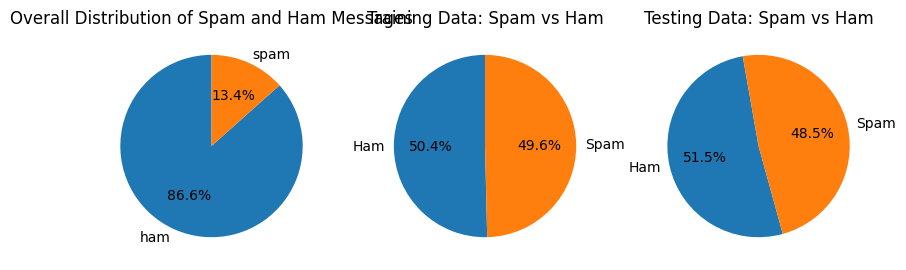

In [2]:
import matplotlib.pyplot as plt

overall_counts = sms_data['v1'].value_counts()
labels = overall_counts.index
sizes = overall_counts.values

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Overall Distribution of Spam and Ham Messages')

train_counts = y_train.value_counts()
labels = ['Ham', 'Spam']
sizes = train_counts.values

plt.subplot(1, 3, 2)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90)
plt.title('Training Data: Spam vs Ham')

test_counts = y_test.value_counts()
labels = ['Ham', 'Spam']
sizes = test_counts.values

plt.subplot(1, 3, 3)
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=100)
plt.title('Testing Data: Spam vs Ham')

plt.show()


In [3]:
# Number of training samples for ham and spam
train_ham_count = (y_train == 0).sum()
train_spam_count = (y_train == 1).sum()

print("Number of training samples - Ham:", train_ham_count)
print("Number of training samples - Spam:", train_spam_count)

# Number of test samples for ham and spam
test_ham_count = (y_test == 0).sum()
test_spam_count = (y_test == 1).sum()

print("\nNumber of test samples - Ham:", test_ham_count)
print("Number of test samples - Spam:", test_spam_count)

# Print head of training data
print("\nHead of training data:")
print(X_train.head())
print(y_train.head())

# Print head of test data
print("\nHead of test data:")
print(X_test.head())
print(y_test.head())


Number of training samples - Ham: 593
Number of training samples - Spam: 602

Number of test samples - Ham: 154
Number of test samples - Spam: 145

Head of training data:
787     ever thought living good life perfect partner ...
1327    ur balance 500 ur next question sang uptown gi...
1191          come home one last time wont anything trust
3911    important customer service announcement call f...
772                  idc get weaseling way shit twice row
Name: clean_text, dtype: object
787     1
1327    1
1191    0
3911    1
772     0
Name: v1, dtype: int64

Head of test data:
4693    pls give food preferably pap slowly load sugar...
3988    ok lor anyway thk cant get ticket co like quit...
16                                        oh kim watching
3313                  oh gei happend tron maybe ill dl 3d
3590                          much would cost hire hitman
Name: clean_text, dtype: object
4693    0
3988    0
16      0
3313    0
3590    0
Name: v1, dtype: int64


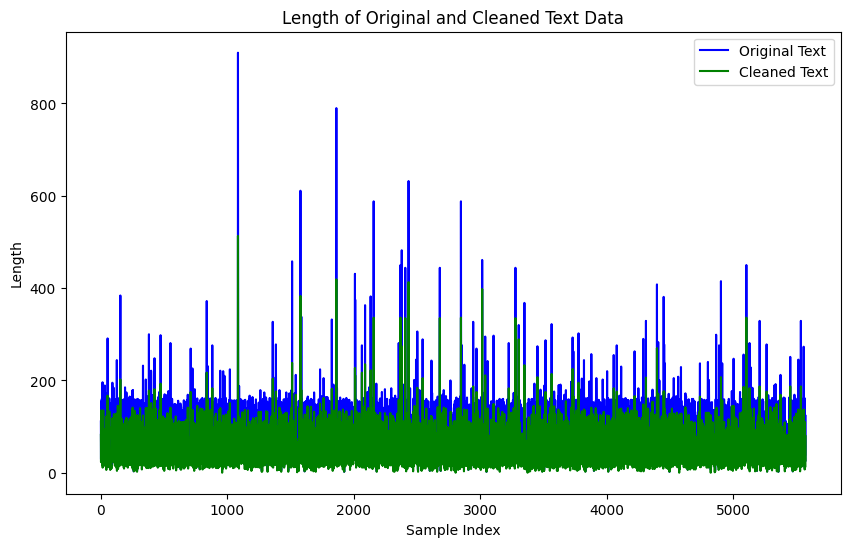

In [4]:
original_lengths = [len(text) for text in sms_data['v2']]
cleaned_lengths = [len(text) for text in sms_data['clean_text']]

plt.figure(figsize=(10, 6))
plt.plot(original_lengths, label='Original Text', color='blue')
plt.plot(cleaned_lengths, label='Cleaned Text', color='green')
plt.title('Length of Original and Cleaned Text Data')
plt.xlabel('Sample Index')
plt.ylabel('Length')
plt.legend()
plt.show()


In [5]:
# Define the model
import torch.nn as nn
import torch.nn.functional as F

class InputEmbedding(nn.Module):
    def __init__(self, vocab_size, d_model):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, d_model)

    def forward(self, x):
        x = x.long()
        return self.embedding(x)

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5573):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe = torch.zeros(max_len, d_model)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(1).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.self_attn = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)
        self.activation = F.relu

    def forward(self, src, src_mask=None, src_key_padding_mask=None):
        src2 = self.self_attn(src, src, src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)[0]
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        src2 = self.linear2(self.dropout(self.activation(self.linear1(src))))
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TransformerEncoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])

    def forward(self, src, mask=None, src_key_padding_mask=None):
        for layer in self.layers:
            src = layer(src, src_mask=mask, src_key_padding_mask=src_key_padding_mask)
        return src

class TransformerDecoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.mha_self = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.ln1 = nn.LayerNorm(d_model)
        self.mha_src = nn.MultiheadAttention(d_model, nhead, dropout=dropout)
        self.ln2 = nn.LayerNorm(d_model)
        self.ffn = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
        )

    def forward(self, trg, enc_src, trg_mask=None, src_mask=None, trg_key_padding_mask=None, src_key_padding_mask=None):
        x, _ = self.mha_self(trg, trg, trg, attn_mask=trg_mask, key_padding_mask=trg_key_padding_mask)
        x = self.ln1(x)
        x, _ = self.mha_src(x, enc_src, enc_src, attn_mask=src_mask, key_padding_mask=src_key_padding_mask)
        x = self.ln2(x)
        x = x + self.ffn(x)
        return x

class TransformerDecoder(nn.Module):
    def __init__(self, decoder_layer, num_layers):
        super().__init__()
        self.layers = nn.ModuleList([decoder_layer for _ in range(num_layers)])

    def forward(self, x, enc_src, trg_mask=None, src_mask=None, trg_key_padding_mask=None, src_key_padding_mask=None):
        for layer in self.layers:
            x = layer(x, enc_src, trg_mask=trg_mask, src_mask=src_mask, trg_key_padding_mask=trg_key_padding_mask, src_key_padding_mask=src_key_padding_mask)
        return x

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model, nhead, num_layers, dim_feedforward=2048, dropout=0.1):
        super().__init__()
        self.embedding = InputEmbedding(vocab_size, d_model)
        self.pos_encoding = PositionalEncoding(d_model, dropout)
        self.encoder = TransformerEncoder(TransformerEncoderLayer(d_model, nhead, dim_feedforward, dropout), num_layers)
        self.decoder = TransformerDecoder(TransformerDecoderLayer(d_model, nhead, dim_feedforward, dropout), num_layers)
        self.fc = nn.Linear(d_model, 2)

    def forward(self, x, enc_x=None):
        x = self.embedding(x) * torch.sqrt(torch.tensor(self.embedding.embedding.embedding_dim, device=x.device))
        x = self.pos_encoding(x)
        if enc_x is not None:
            enc_x = self.encoder(enc_x)
            x = self.decoder(x, enc_x)
        x = self.fc(x[:, 0, :])
        return x
class SimpleClassifier(nn.Module):
    def __init__(self, input_dim):
        super(SimpleClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 2)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


In [30]:
import matplotlib.pyplot as plt
accuracies=[]
# Model instantiation
input_dim = X_train_tensor.shape[1]
model = SimpleClassifier(input_dim)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

# Lists to store training and testing accuracies
train_accuracies = []
test_accuracies = []

# Training function
def train(model, criterion, optimizer, X_train, y_train, X_test, y_test, epochs=10, batch_size=64):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        correct_train = 0
        total_train = 0
        correct_test = 0
        total_test = 0
        for i in range(0, len(X_train), batch_size):
            inputs = X_train[i:i+batch_size]
            labels = y_train[i:i+batch_size]
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted_train = torch.max(outputs.data, 1)
            total_train += labels.size(0)
            correct_train += (predicted_train == labels).sum().item()
        epoch_loss = running_loss / len(X_train)
        epoch_acc_train = correct_train / total_train
        train_accuracies.append(epoch_acc_train)

        # Calculate testing accuracy
        model.eval()
        with torch.no_grad():
            for i in range(0, len(X_test), batch_size):
                inputs_test = X_test[i:i+batch_size]
                labels_test = y_test[i:i+batch_size]
                outputs_test = model(inputs_test)
                _, predicted_test = torch.max(outputs_test.data, 1)
                total_test += labels_test.size(0)
                correct_test += (predicted_test == labels_test).sum().item()
            epoch_acc_test = correct_test / total_test
            test_accuracies.append(epoch_acc_test)

        print(f'Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc_train:.4f}')

# Train the model
train(model, criterion, optimizer, X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor)

# Evaluate overall accuracy
def evaluate_overall_accuracy(model, X_test, y_test, batch_size=64):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs = X_test[i:i+batch_size]
            labels = y_test[i:i+batch_size]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    overall_accuracy = correct / total
    print(f'Overall Accuracy: {overall_accuracy:.4f}')
    accuracies.append(overall_accuracy*100)
    return overall_accuracy

overall_accuracy = evaluate_overall_accuracy(model, X_test_tensor, y_test_tensor)



Epoch 1/10, Loss: 0.0109, Train Accuracy: 0.5038
Epoch 2/10, Loss: 0.0105, Train Accuracy: 0.5180
Epoch 3/10, Loss: 0.0095, Train Accuracy: 0.8276
Epoch 4/10, Loss: 0.0078, Train Accuracy: 0.9690
Epoch 5/10, Loss: 0.0058, Train Accuracy: 0.9858
Epoch 6/10, Loss: 0.0040, Train Accuracy: 0.9908
Epoch 7/10, Loss: 0.0027, Train Accuracy: 0.9925
Epoch 8/10, Loss: 0.0018, Train Accuracy: 0.9925
Epoch 9/10, Loss: 0.0012, Train Accuracy: 0.9950
Epoch 10/10, Loss: 0.0008, Train Accuracy: 0.9967
Overall Accuracy: 0.9866


In [23]:
print(test_accuracies)

[0.6956521739130435, 0.8160535117056856, 0.8896321070234113, 0.9264214046822743, 0.9698996655518395, 0.9832775919732442, 0.9899665551839465, 0.9866220735785953, 0.9866220735785953, 0.9866220735785953]


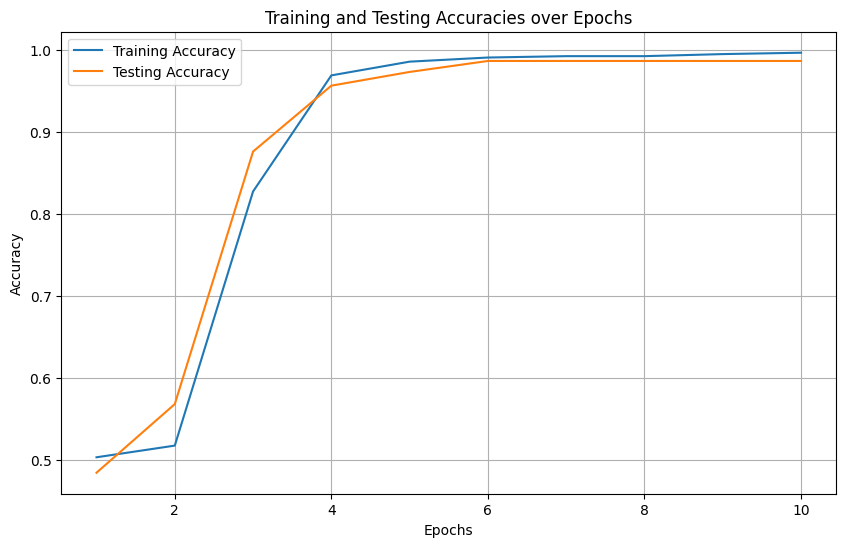

In [31]:

# Plotting the accuracies
plt.figure(figsize=(10, 6))
epochs = range(1, len(train_accuracies) + 1)
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, test_accuracies, label='Testing Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracies over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [25]:


def predict_message_simple_classifier(model, message, count_vectorizer):
    # Preprocess the user input
    message = preprocess_text(message)

    message_vectorized = count_vectorizer.transform([message])

    # Convert the sparse matrix to tensor and float
    message_tensor = torch.tensor(message_vectorized.toarray()).float()

    # Make the prediction
    with torch.no_grad():
        output = model(message_tensor)
        predicted_class = torch.argmax(output)

    # Map the predicted class to spam or ham
    if predicted_class == 0:
        prediction = "ham"
    else:
        prediction = "spam"

    return prediction


# Use the trained model to predict message class
user_message = input("Enter your text message: ")
prediction = predict_message_simple_classifier(model, user_message, count_vectorizer)
print(f"The predicted class is: {prediction}")


Enter your text message: hi
The predicted class is: ham


In [32]:
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score

def evaluate_model(model, X_test, y_test, batch_size=64):
    model.eval()
    predictions = []
    with torch.no_grad():
        for i in range(0, len(X_test), batch_size):
            inputs = X_test[i:i+batch_size]
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predictions.extend(predicted.cpu().numpy())
    y_pred = np.array(predictions)

    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)

    # Print metrics
    print(f'F1 Score: {f1:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print('Confusion Matrix:')
    print(cm)

# Evaluate the model
evaluate_model(model, X_test_tensor, y_test_tensor)


F1 Score: 0.9861
Precision: 0.9930
Recall: 0.9793
Confusion Matrix:
[[153   1]
 [  3 142]]


In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, f1_score, recall_score, confusion_matrix

# Random Forest Classifier
rf_classifier = RandomForestClassifier()
rf_classifier.fit(X_train_vectorized, y_train)
rf_predictions = rf_classifier.predict(X_test_vectorized)

# Naive Bayes Classifier
nb_classifier = MultinomialNB()
nb_classifier.fit(X_train_vectorized, y_train)
nb_predictions = nb_classifier.predict(X_test_vectorized)

# Logistic Regression Classifier
logistic_classifier = LogisticRegression()
logistic_classifier.fit(X_train_vectorized, y_train)
logistic_predictions = logistic_classifier.predict(X_test_vectorized)

# Evaluate models
def evaluate_model(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return acc, f1, recall, cm

# Evaluate Random Forest Classifier
rf_acc, rf_f1, rf_recall, rf_cm = evaluate_model(y_test, rf_predictions)

# Evaluate Naive Bayes Classifier
nb_acc, nb_f1, nb_recall, nb_cm = evaluate_model(y_test, nb_predictions)

# Evaluate Logistic Regression Classifier
logistic_acc, logistic_f1, logistic_recall, logistic_cm = evaluate_model(y_test, logistic_predictions)

print("Random Forest Classifier:")
print(f"Accuracy: {rf_acc}")
print(f"F1 Score: {rf_f1}")
print(f"Recall: {rf_recall}")
print(f"Confusion Matrix:\n{rf_cm}")

print("\nNaive Bayes Classifier:")
print(f"Accuracy: {nb_acc}")
print(f"F1 Score: {nb_f1}")
print(f"Recall: {nb_recall}")
print(f"Confusion Matrix:\n{nb_cm}")

print("\nLogistic Regression Classifier:")
print(f"Accuracy: {logistic_acc}")
print(f"F1 Score: {logistic_f1}")
print(f"Recall: {logistic_recall}")
print(f"Confusion Matrix:\n{logistic_cm}")

accuracies.append(rf_acc*100)
accuracies.append(nb_acc*100)
accuracies.append(logistic_acc*100)
print(accuracies)

Random Forest Classifier:
Accuracy: 0.979933110367893
F1 Score: 0.9790209790209791
Recall: 0.9655172413793104
Confusion Matrix:
[[153   1]
 [  5 140]]

Naive Bayes Classifier:
Accuracy: 0.959866220735786
F1 Score: 0.9600000000000001
Recall: 0.993103448275862
Confusion Matrix:
[[143  11]
 [  1 144]]

Logistic Regression Classifier:
Accuracy: 0.9765886287625418
F1 Score: 0.9752650176678445
Recall: 0.9517241379310345
Confusion Matrix:
[[154   0]
 [  7 138]]
[98.66220735785953, 97.9933110367893, 95.9866220735786, 97.65886287625418]


[98.66220735785953, 97.9933110367893, 95.9866220735786, 97.65886287625418]


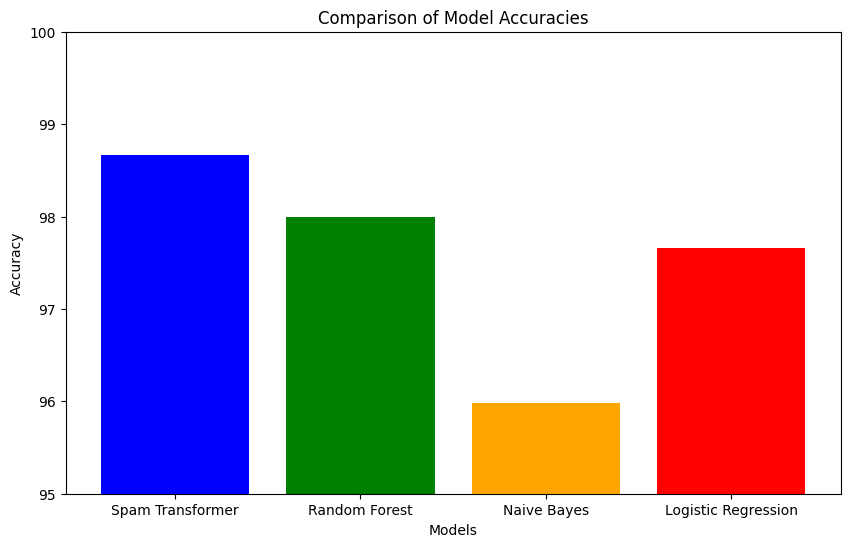

In [34]:
import matplotlib.pyplot as plt

# List of model names
models = ['Spam Transformer', 'Random Forest', 'Naive Bayes', 'Logistic Regression']
print(accuracies)

# Plotting the bar graph
plt.figure(figsize=(10, 6))
plt.bar(models, accuracies, color=['blue', 'green', 'orange', 'red'])
plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.ylim(95, 100)
plt.show()
